<a href="https://colab.research.google.com/github/aytha-rajesh/lakehead/blob/master/1105343_1dconv_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import pandas lib to read our dataset
import pandas as pd

#Get train/test split package from sklearn for preparing our dataset to train and test model with
from sklearn.model_selection import train_test_split

#import the numpy library to work with and manipulate the data
import numpy as np
import matplotlib.pyplot as plt 

Loading the Dataset
and printing first 10 rows


In [0]:
dataset=pd.read_csv('/content/housing.csv')
dataset=dataset.dropna()
print("here are the first ten rows of the dataset:")
dataset.head(10)


here are the first ten rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700,NEAR BAY
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200,NEAR BAY
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400,NEAR BAY
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700,NEAR BAY
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100,NEAR BAY


Plotting the features of dataset


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06914dc908>,
      dtype=object)

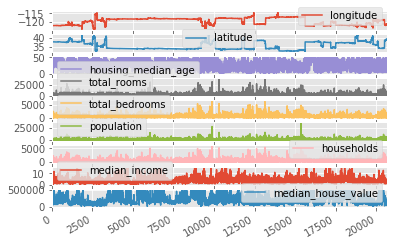

In [0]:
plt.style.use('ggplot') 
dataset.plot(subplots=True)


Splitting Dataset into input X and output Y

In [0]:
#we will predict the "median_house_value" col using rest of the columns
y=dataset['median_house_value']

x=dataset.loc[:,'longitude':'median_income']

Splitting Dataset into tarining and testing in 70:30 portion

In [0]:
#split dataset so 70% will be train set and 30% will be test set
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3)
#convert the dataset to numpy arrays to work with pytorch model
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()
#convert the testing test
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()


Creating Network

In [0]:
import torch
#import 1D convolution layer
from torch.nn import Conv1d
#import the max pooling layer
from torch.nn import MaxPool1d
#import flattern layer
from torch.nn import Flatten
#import linear layer
from torch.nn import Linear
#import relu activation function
from torch.nn.functional import relu
#import DataLoader, TensorDataset lib from pytorch to work with our dataset
from torch.utils.data import DataLoader, TensorDataset

Defining our Model

In [0]:
#our class must be a class of torch.nn.Module
class CnnRegressor(torch.nn.Module):
  #Define intialization method
  def __init__(self,batch_size,inputs,outputs):
    #initalize the superclas and store the parameters
    super(CnnRegressor,self).__init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    #define input layer
    #(input channel,output channel,kernel size)
    self.input_layer=Conv1d(inputs,batch_size,1)
    self.max_pooling_layer=MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    self.flattern_layer=Flatten()

    self.linear_layer=Linear(128,64)
    #Finally,define the output layer
    self.output_layer=Linear(64,outputs)
  #Define a method to feed inputs through the model
  def feed(self,input):
    #Reshape the entry so it can be fed to the input layer
    input=input.reshape((self.batch_size,self.inputs,1))
  
    #Get the output of the frst layer at pass it to relu function
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flattern_layer(output)
    output=self.linear_layer(output)
    output=self.output_layer(output)
    return output    

Training the Model(importing optimizer and performance measure)

In [0]:
#Traning the mdel
#import RMSProp from pytorch for our optimizer
from torch.optim import RMSprop 

from torch.nn import L1Loss
#import the r^2 score package from pytorch ignite for our score measure
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 9.5MB/s 


Defining our Model

In [0]:
#lets define our model
batch_size=64
#(batchsize, xcol,ycol)
model=CnnRegressor(batch_size,x.shape[1],1)
#set the mdoel to use GPU fro processing
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flattern_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

Creating a method for running batches of data through our model

In [0]:
#This method will return the average L1 loss and R^2 score 
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss+=loss.item()
    avg_score+=score
    count+=1
  return avg_loss/count, avg_score/count

Training the model

In [0]:
epochs=100
optimizer=RMSprop(model.parameters(), lr=1e-3)
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()


tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

#start the training loop
for epoch in range(epochs):
  avg_loss, avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)
  print("Epoch"+str(epoch +1)+ ":\n\tLoss=" +str(avg_loss) + "\n\tR^2 Score=" +str(avg_r2_score))


Epoch1:
	Loss=115672.74691704036
	R^2 Score=-1.2812248969155084
Epoch2:
	Loss=90750.27902536435
	R^2 Score=-0.3626285714747453
Epoch3:
	Loss=81328.71684066704
	R^2 Score=0.13418449204972058
Epoch4:
	Loss=79558.3301919843
	R^2 Score=0.20922488443683712
Epoch5:
	Loss=78194.55647421525
	R^2 Score=0.21575647305326381
Epoch6:
	Loss=76627.67709501121
	R^2 Score=0.24948537421610997
Epoch7:
	Loss=74808.59105241031
	R^2 Score=0.2922614815152288
Epoch8:
	Loss=72815.27282441144
	R^2 Score=0.33938624368247244
Epoch9:
	Loss=71204.26189391816
	R^2 Score=0.3489756340580797
Epoch10:
	Loss=69473.4394443666
	R^2 Score=0.3860004130252787
Epoch11:
	Loss=68293.95408842489
	R^2 Score=0.4033368316481117
Epoch12:
	Loss=67368.82146860987
	R^2 Score=0.41089995990198
Epoch13:
	Loss=66148.90942054373
	R^2 Score=0.4272134392397307
Epoch14:
	Loss=65628.14899803812
	R^2 Score=0.44015264560090894
Epoch15:
	Loss=64758.079824131164
	R^2 Score=0.44927928438354525
Epoch16:
	Loss=64224.905356642375
	R^2 Score=0.4347263562

In [0]:
#finally we will test model to see how it performs on testing dataset
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

avg_loss, avg_r2_score=model_loss(model,loader)
print("the mode's l1 loss is:"+str(avg_loss))
print("the model's R^2 score is:" +str(avg_r2_score))


the mode's l1 loss is:50733.45518092105
the model's R^2 score is:0.6165311234605623
